In [22]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

/g/data/fu5/deg581/python_envs/devel3.7/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38491 instead
  f"Port {expected} is already in use.\n"


In [23]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38491/status,
Dashboard: /proxy/38491/status,Workers: 4
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34483,Workers: 4
Dashboard: /proxy/38491/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://10.0.128.149:33001,Total threads: 4
Dashboard: /proxy/40243/status,Memory: 11.23 GiB
Nanny: tcp://127.0.0.1:46513,


In [24]:
cd /g/data/fu5/deg581/OSSE_analysis/notebooks/

/g/data1a/fu5/deg581/OSSE_analysis/notebooks


In [25]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)


loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


### Load functions

In [26]:
### Other local functions

def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = glob.glob(hisFilePath+prefix+filestring)

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

#     for files in filelist: 
#         print(files)
    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

### function to load overlapping OSSE data
def loadOverlappedNetcdf(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    # err=err2**(1/2)
    mse = indexMeanMetric(err2,etaRange,xiRange) #mean square error MSE
    output = mse**(1/2)
    return mse,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    ''' iRange and jRange are converted to slices, so they are the start/end values of the range '''
    output = input.isel(eta_rho=slice(etaRange[0],etaRange[1]), xi_rho=slice(xiRange[0],xiRange[1])).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def plot_spatialMapSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def plot_spatialMapGSSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

def datestring_to_serial_day(datestring,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import pandas as pd
    import datetime
    serial_day_timedelta = pd.to_datetime(datestring) - datetime.datetime(epochY,epochm,epochd,epochH,epochM)
    corrected_serial_day_number = serial_day_timedelta.days + serial_day_timedelta.seconds/86400
    return corrected_serial_day_number


def serial_day_to_datestring(day,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import datetime
    corrected_date = datetime.datetime(epochY,epochm,epochd,epochH,epochM) + datetime.timedelta(day)
    return corrected_date.strftime("%Y-%m-%d %H:%M")  

In [27]:
### Functions for calculating metrics

def loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates):
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    return sshForecast, sshAnalysis, sstForecast, sstAnalysis

def loadTruthdata(hisTruthFilePath,prefixTruth,dates):
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()
    return sshTruth, sstTruth

def compileOSSETimeMetricSSH(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
            temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
    return ssh_metricForecast,ssh_metricAnalysis

def compileOSSETimeMetricSST(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricForecast = xr.merge([sst_metricForecast, temp])
            temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
    return sst_metricForecast,sst_metricAnalysis

def compileTruthTimeMetric(hisTruthFilePath,prefixTruth,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshTruth,sstTruth = loadTruthdata(hisTruthFilePath,prefixTruth,dates)
        if dates == datelist[0]:
            ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
            temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = xr.merge([sst_metricTruth, temp])
    return ssh_metricTruth, sst_metricTruth

In [28]:
### Functions for loading and processing ROMS data nicely... ROMS FUNCTIONS

from xgcm import Grid

def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    periodic=False)
    return gridOut

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho'],
                                    method='linear').squeeze()
    return output

In [29]:
hisTruthFilePath='/g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/' # Truth file settings

hisOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
modOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
obsOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'

hisOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
modOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
obsOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'

hisOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
modOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
obsOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'

hisOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
modOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
obsOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'

prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
prefixTruth='outer_his_'
prefixObs='obs_0'
prefixMod='eac_mod_'
prefixPert='outer_his_'

outFigurePath='../cache/out/'

In [30]:
timeRange = [8005, 8185]
datelist = np.array(range(timeRange[0],timeRange[1],4))


In [31]:

def loadOSSEFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadOverlappedNetcdfFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

In [32]:
def generateFileList(hisFilePath,prefix,datelist):
    filelist=[hisFilePath+prefix+'0'+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=hisFilePath+prefix+'0'+str(dates)+'.nc'
        filelist.append(filenameToAppend)

#         print(filelist)
    return filelist


filelistTruth=generateFileList(hisTruthFilePath,prefixTruth,datelist)
filelist_SSHSST=generateFileList(hisOSSEFilePath1,prefixAnalysis,datelist)
filelist_SSHSST_XBT=generateFileList(hisOSSEFilePath2,prefixAnalysis,datelist)
filelist_SSHSST_XBT_N=generateFileList(hisOSSEFilePath3,prefixAnalysis,datelist)
filelist_SSHSST_XBT_S=generateFileList(hisOSSEFilePath4,prefixAnalysis,datelist)

truth=loadOverlappedNetcdfFileList(hisTruthFilePath,prefixTruth,filelist=filelistTruth,overlapDays=7)
OSSE_SSHSST=loadOSSEFileList(hisOSSEFilePath1,prefixAnalysis, filelist=filelist_SSHSST,overlapDays=7)
OSSE_SSHSST_XBT=loadOSSEFileList(hisOSSEFilePath2,prefixAnalysis, filelist=filelist_SSHSST_XBT,overlapDays=7)
OSSE_SSHSST_XBT_N=loadOSSEFileList(hisOSSEFilePath3,prefixAnalysis, filelist=filelist_SSHSST_XBT_N,overlapDays=7)
OSSE_SSHSST_XBT_S=loadOSSEFileList(hisOSSEFilePath4,prefixAnalysis, filelist=filelist_SSHSST_XBT_S,overlapDays=7)

loaded from /g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/outer_his_08005.nc to /g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/outer_his_08181.nc
loaded from /g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/roms_fwd_outer1_08005.nc to /g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/roms_fwd_outer1_08181.nc
loaded from /g/data/fu5/deg581/OSSE_SSHSST_XBT/output/roms_fwd_outer1_08005.nc to /g/data/fu5/deg581/OSSE_SSHSST_XBT/output/roms_fwd_outer1_08181.nc
loaded from /g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/roms_fwd_outer1_08005.nc to /g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/roms_fwd_outer1_08181.nc
loaded from /g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/roms_fwd_outer1_08005.nc to /g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/roms_fwd_outer1_08181.nc


In [33]:
# process into more useful format
truth = processROMSGrid(truth)
OSSE_SSHSST=processROMSGrid(OSSE_SSHSST)
OSSE_SSHSST_XBT=processROMSGrid(OSSE_SSHSST_XBT)
OSSE_SSHSST_XBT_N=processROMSGrid(OSSE_SSHSST_XBT_N)
OSSE_SSHSST_XBT_S=processROMSGrid(OSSE_SSHSST_XBT_S)

In [34]:
grid = makeROMSGridObject(truth)

In [35]:
# calculate metrics

# RMSD_SSHSST_TRUTH_u_east  = (((OSSE_SSHSST.u_eastward.isel(s_rho=-1)-truth.u_eastward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_TRUTH_v_north = (((OSSE_SSHSST.v_northward.isel(s_rho=-1)-truth.v_northward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
RMSD_SSHSST_TRUTH_temp    = (((OSSE_SSHSST.temp.isel(s_rho=-1)-truth.temp.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
RMSD_SSHSST_TRUTH_temp500 = (((horizontalSectionROMS(grid, OSSE_SSHSST.temp, np.array([-500]))-horizontalSectionROMS(grid, truth.temp, np.array([-500])))**2).mean(dim='ocean_time'))**(1/2)
# RMSD_SSHSST_TRUTH_zeta    = (((OSSE_SSHSST.zeta-truth.zeta)**2).mean(dim="ocean_time"))**(1/2)

# RMSD_SSHSST_XBT_N_TRUTH_u_east  = (((OSSE_SSHSST_XBT_N.u_eastward.isel(s_rho=-1)-truth.u_eastward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_XBT_N_TRUTH_v_north = (((OSSE_SSHSST_XBT_N.v_northward.isel(s_rho=-1)-truth.v_northward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
RMSD_SSHSST_XBT_N_TRUTH_temp    = (((OSSE_SSHSST_XBT_N.temp.isel(s_rho=-1)-truth.temp.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
RMSD_SSHSST_XBT_N_TRUTH_temp500 = (((horizontalSectionROMS(grid, OSSE_SSHSST_XBT_N.temp, np.array([-500]))-horizontalSectionROMS(grid, truth.temp, np.array([-500])))**2).mean(dim='ocean_time'))**(1/2)
# RMSD_SSHSST_XBT_N_TRUTH_zeta    = (((OSSE_SSHSST_XBT_N.zeta-truth.zeta)**2).mean(dim="ocean_time"))**(1/2)

# RMSD_SSHSST_XBT_S_TRUTH_u_east  = (((OSSE_SSHSST_XBT_S.u_eastward.isel(s_rho=-1)-truth.u_eastward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_XBT_S_TRUTH_v_north = (((OSSE_SSHSST_XBT_S.v_northward.isel(s_rho=-1)-truth.v_northward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
RMSD_SSHSST_XBT_S_TRUTH_temp    = (((OSSE_SSHSST_XBT_S.temp.isel(s_rho=-1)-truth.temp.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
RMSD_SSHSST_XBT_S_TRUTH_temp500 = (((horizontalSectionROMS(grid, OSSE_SSHSST_XBT_S.temp, np.array([-500]))-horizontalSectionROMS(grid, truth.temp, np.array([-500])))**2).mean(dim='ocean_time'))**(1/2)
# RMSD_SSHSST_XBT_S_TRUTH_zeta    = (((OSSE_SSHSST_XBT_S.zeta-truth.zeta)**2).mean(dim="ocean_time"))**(1/2)

# RMSD_SSHSST_XBT_TRUTH_u_east  = (((OSSE_SSHSST_XBT.u_eastward.isel(s_rho=-1)-truth.u_eastward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_XBT_TRUTH_v_north = (((OSSE_SSHSST_XBT.v_northward.isel(s_rho=-1)-truth.v_northward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
RMSD_SSHSST_XBT_TRUTH_temp    = (((OSSE_SSHSST_XBT.temp.isel(s_rho=-1)-truth.temp.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
RMSD_SSHSST_XBT_TRUTH_temp500 = (((horizontalSectionROMS(grid, OSSE_SSHSST_XBT.temp, np.array([-500]))-horizontalSectionROMS(grid, truth.temp, np.array([-500])))**2).mean(dim='ocean_time'))**(1/2)
# RMSD_SSHSST_XBT_TRUTH_zeta    = (((OSSE_SSHSST_XBT.zeta-truth.zeta)**2).mean(dim="ocean_time"))**(1/2)

In [36]:
# RMSD_SSHSST_TRUTH_u_east.load()
# RMSD_SSHSST_TRUTH_v_north.load()
RMSD_SSHSST_TRUTH_temp.load()
RMSD_SSHSST_TRUTH_temp500.load()
# RMSD_SSHSST_TRUTH_zeta.load()

# RMSD_SSHSST_XBT_N_TRUTH_u_east.load()
# RMSD_SSHSST_XBT_N_TRUTH_v_north.load()
RMSD_SSHSST_XBT_N_TRUTH_temp.load()
RMSD_SSHSST_XBT_N_TRUTH_temp500.load()
# RMSD_SSHSST_XBT_N_TRUTH_zeta.load()
# RMSD_SSHSST_XBT_S_TRUTH_u_east.load()
# RMSD_SSHSST_XBT_S_TRUTH_v_north.load()
RMSD_SSHSST_XBT_S_TRUTH_temp.load()
RMSD_SSHSST_XBT_S_TRUTH_temp500.load()
# RMSD_SSHSST_XBT_S_TRUTH_zeta.load()

# RMSD_SSHSST_XBT_TRUTH_u_east.load()
# RMSD_SSHSST_XBT_TRUTH_v_north.load()
RMSD_SSHSST_XBT_TRUTH_temp.load()
RMSD_SSHSST_XBT_TRUTH_temp500.load()
# RMSD_SSHSST_XBT_TRUTH_zeta.load()

<xarray.DataArray 'temp' (eta_rho: 317, xi_rho: 272)>
array([[           nan,            nan,            nan, ...,
        2.53247478e-04, 2.61181865e-04, 9.86575789e-02],
       [           nan,            nan,            nan, ...,
        5.61053165e-01, 5.87864774e-01, 1.97394722e-01],
       [           nan,            nan,            nan, ...,
        5.34913312e-01, 5.76177014e-01, 2.99262615e-01],
       ...,
       [           nan,            nan,            nan, ...,
        8.94472876e-01, 9.05327211e-01, 5.38081431e-01],
       [           nan,            nan,            nan, ...,
        9.19079625e-01, 9.28922908e-01, 4.94904317e-01],
       [           nan,            nan,            nan, ...,
        5.50345079e-01, 4.74413880e-01, 4.74935966e-01]])
Coordinates:
    lon_rho  (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.1 162.2 162.2
    lat_rho  (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
    z_rho    int64 -500
Dimensions without coordinates: eta_rho, xi_rho

In [37]:
# I_XBT_N_u       = (RMSD_SSHSST_TRUTH_u_east - RMSD_SSHSST_XBT_N_TRUTH_u_east)/RMSD_SSHSST_TRUTH_u_east*100
# I_XBT_N_v       = (RMSD_SSHSST_TRUTH_v_north - RMSD_SSHSST_XBT_N_TRUTH_v_north)/RMSD_SSHSST_TRUTH_v_north*100
I_XBT_N_temp    = (RMSD_SSHSST_TRUTH_temp - RMSD_SSHSST_XBT_N_TRUTH_temp)/RMSD_SSHSST_TRUTH_temp*100
I_XBT_N_temp500 = (RMSD_SSHSST_TRUTH_temp500 - RMSD_SSHSST_XBT_N_TRUTH_temp500)/RMSD_SSHSST_TRUTH_temp500*100
# I_XBT_N_zeta    = (RMSD_SSHSST_TRUTH_zeta - RMSD_SSHSST_XBT_N_TRUTH_zeta)/RMSD_SSHSST_TRUTH_zeta*100

# I_XBT_S_u       = (RMSD_SSHSST_TRUTH_u_east - RMSD_SSHSST_XBT_S_TRUTH_u_east)/RMSD_SSHSST_TRUTH_u_east*100
# I_XBT_S_v       = (RMSD_SSHSST_TRUTH_v_north - RMSD_SSHSST_XBT_S_TRUTH_v_north)/RMSD_SSHSST_TRUTH_v_north*100
I_XBT_S_temp    = (RMSD_SSHSST_TRUTH_temp - RMSD_SSHSST_XBT_S_TRUTH_temp)/RMSD_SSHSST_TRUTH_temp*100
I_XBT_S_temp500 = (RMSD_SSHSST_TRUTH_temp500 - RMSD_SSHSST_XBT_S_TRUTH_temp500)/RMSD_SSHSST_TRUTH_temp500*100
# I_XBT_S_zeta    = (RMSD_SSHSST_TRUTH_zeta - RMSD_SSHSST_XBT_S_TRUTH_zeta)/RMSD_SSHSST_TRUTH_zeta*100

# I_XBT_u       = (RMSD_SSHSST_TRUTH_u_east - RMSD_SSHSST_XBT_S_TRUTH_u_east)/RMSD_SSHSST_TRUTH_u_east*100
# I_XBT_v       = (RMSD_SSHSST_TRUTH_v_north - RMSD_SSHSST_XBT_TRUTH_v_north)/RMSD_SSHSST_TRUTH_v_north*100
I_XBT_temp    = (RMSD_SSHSST_TRUTH_temp - RMSD_SSHSST_XBT_TRUTH_temp)/RMSD_SSHSST_TRUTH_temp*100
I_XBT_temp500 = (RMSD_SSHSST_TRUTH_temp500 - RMSD_SSHSST_XBT_TRUTH_temp500)/RMSD_SSHSST_TRUTH_temp500*100
# I_XBT_zeta    = (RMSD_SSHSST_TRUTH_zeta - RMSD_SSHSST_XBT_TRUTH_zeta)/RMSD_SSHSST_TRUTH_zeta*100

In [38]:
# # F_SSH_SST_u       = (RMSD_SSHSST_TRUTH_u_east) /truth.u_eastward.isel(s_rho=-1).std(dim='ocean_time',skipna=True)*100
# # F_SSH_SST_v       = (RMSD_SSHSST_TRUTH_v_north)/truth.v_northward.isel(s_rho=-1).std(dim='ocean_time',skipna=True)*100
# F_SSH_SST_temp    = (RMSD_SSHSST_TRUTH_temp)   /truth.temp.isel(s_rho=-1).std(dim='ocean_time',skipna=True)*100
# F_SSH_SST_temp500 = (RMSD_SSHSST_TRUTH_temp500)/horizontalSectionROMS(grid, truth.temp, np.array([-500])).std(dim='ocean_time',skipna=True)*100
# # F_SSH_SST_zeta    = (RMSD_SSHSST_TRUTH_zeta)   /truth.zeta.std(dim='ocean_time',skipna=True)*100

# # F_XBT_N_u       = (RMSD_SSHSST_XBT_N_TRUTH_u_east) /truth.u_eastward.isel(s_rho=-1).std(dim='ocean_time',skipna=True)*100
# # F_XBT_N_v       = (RMSD_SSHSST_XBT_N_TRUTH_v_north)/truth.v_northward.isel(s_rho=-1).std(dim='ocean_time',skipna=True)*100
# F_XBT_N_temp    = (RMSD_SSHSST_XBT_N_TRUTH_temp)   /truth.temp.isel(s_rho=-1).std(dim='ocean_time',skipna=True)*100
# F_XBT_N_temp500 = (RMSD_SSHSST_XBT_N_TRUTH_temp500)/horizontalSectionROMS(grid, truth.temp, np.array([-500])).std(dim='ocean_time',skipna=True)*100
# # F_XBT_N_zeta    = (RMSD_SSHSST_XBT_N_TRUTH_zeta)   /truth.zeta.std(dim='ocean_time',skipna=True)*100

# # F_XBT_S_u       = (RMSD_SSHSST_XBT_S_TRUTH_u_east) /truth.u_eastward.isel(s_rho=-1).std(dim='ocean_time',skipna=True)*100
# # F_XBT_S_v       = (RMSD_SSHSST_XBT_S_TRUTH_v_north)/truth.v_northward.isel(s_rho=-1).std(dim='ocean_time',skipna=True)*100
# F_XBT_S_temp    = (RMSD_SSHSST_XBT_S_TRUTH_temp)   /truth.temp.isel(s_rho=-1).std(dim='ocean_time',skipna=True)*100
# F_XBT_S_temp500 = (RMSD_SSHSST_XBT_S_TRUTH_temp500)/horizontalSectionROMS(grid, truth.temp, np.array([-500])).std(dim='ocean_time',skipna=True)*100
# # F_XBT_S_zeta    = (RMSD_SSHSST_XBT_S_TRUTH_zeta)   /truth.zeta.std(dim='ocean_time',skipna=True)*100

# # F_XBT_u       = (RMSD_SSHSST_XBT_TRUTH_u_east) /truth.u_eastward.isel(s_rho=-1).std(dim='ocean_time',skipna=True)*100
# # F_XBT_v       = (RMSD_SSHSST_XBT_TRUTH_v_north)/truth.v_northward.isel(s_rho=-1).std(dim='ocean_time',skipna=True)*100
# F_XBT_temp    = (RMSD_SSHSST_XBT_TRUTH_temp)   /truth.temp.isel(s_rho=-1).std(dim='ocean_time',skipna=True)*100
# F_XBT_temp500 = (RMSD_SSHSST_XBT_TRUTH_temp500)/horizontalSectionROMS(grid, truth.temp, np.array([-500])).std(dim='ocean_time',skipna=True)*100
# # F_XBT_zeta    = (RMSD_SSHSST_XBT_TRUTH_zeta)   /truth.zeta.std(dim='ocean_time',skipna=True)*100

In [39]:
# # F_SSH_SST_u.load()
# # F_SSH_SST_v.load()
# F_SSH_SST_temp.load()
# F_SSH_SST_temp500.load()
# # F_SSH_SST_zeta.load()

# # F_XBT_N_u.load()
# # F_XBT_N_v.load()
# F_XBT_N_temp.load()
# F_XBT_N_temp500.load()
# # F_XBT_N_zeta.load()

# # F_XBT_S_u.load()
# # F_XBT_S_v.load()
# F_XBT_S_temp.load()
# F_XBT_S_temp500.load()
# # F_XBT_S_zeta.load()

# # F_XBT_u.load()
# # F_XBT_v.load()
# F_XBT_temp.load()
# F_XBT_temp500.load()
# # F_XBT_zeta.load()

In [40]:
# ## define

# def spatialMap_addGSSubplot(toPlotData, gs, nrow,ncol, labelText, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
#     ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
#     ax.set_extent([148, 161, -42, -25])
#     feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
#     im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
#     gl = ax.gridlines(draw_labels=True,
#                      color='black', alpha=0.2, linestyle='--')
#     gl.right_labels = False
#     gl.top_labels = False
#     gl.left_labels = False
#     gl.bottom_labels = False
#     cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.07,.39, 1, 1),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
#     fig.colorbar(im, cax=cax)
#     ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
#     ax.set_title('')
#     return ax

# def addSubplot_spatialMap_contourf(input,levels,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
#     ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
#     ax.set_extent([148, 161, -42, -25])
#     feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
#     im = ax.contourf(input.lon_rho,input.lat_rho,input,levels,**pcol_kwargs)   
#     gl = ax.gridlines(draw_labels=True,
#                      color='black', alpha=0.2, linestyle='--')
#     gl.right_labels = False
#     gl.top_labels = False
#     gl.left_labels = False
#     gl.bottom_labels = False
#     cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.07,.39, 1, 1),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
#     fig.colorbar(im, cax=cax)
#     ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
#     ax.set_title('')
#     return ax

# def addSubplot_spatialMap_pcolor(input,levels,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
#     ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
#     ax.set_extent([148, 161, -42, -25])
#     feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
#     im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
#     gl = ax.gridlines(draw_labels=True,
#                      color='black', alpha=0.2, linestyle='--')
#     gl.right_labels = False
#     gl.top_labels = False
#     gl.left_labels = False
#     gl.bottom_labels = False
#     cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.07,.39, 1, 1),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
#     fig.colorbar(im, cax=cax)
#     ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
#     ax.set_title('')
#     return ax




# # gs to make a 4 row, 7 col plot
# gs = gridspec.GridSpec(nrows=5,ncols=5)
# plt.cla()
# plt.clf()
# fig = plt.figure(figsize=[15,22.5])
# ax = None


# levels=np.arange(-100,110,25)

# ## OSSE_SSHSST row
# ax5 = addSubplot_spatialMap_pcolor(F_SSH_SST_u      ,levels,gs,0,0,'a',pcol_kwargs={'cmap':'cmo.balance','vmin':0,'vmax':200})
# ax5.text(0.5, 1.1, 'u',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax5.transAxes)
# ax5.text(-.1, .5, 'SSH+SST',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax5.transAxes)
# ax6 = addSubplot_spatialMap_pcolor(F_SSH_SST_v      ,levels,gs,0,1,'b',pcol_kwargs={'cmap':'cmo.balance','vmin':0,'vmax':200})
# ax6.text(0.5, 1.1, 'v',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax6.transAxes)
# ax7 = addSubplot_spatialMap_pcolor(F_SSH_SST_temp      ,levels,gs,0,2,'c',pcol_kwargs={'cmap':'cmo.balance','vmin':0,'vmax':200})
# ax7.text(0.5, 1.1, 'SST',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax7 = addSubplot_spatialMap_pcolor(F_SSH_SST_temp500      ,levels,gs,0,3,'d',pcol_kwargs={'cmap':'cmo.balance','vmin':0,'vmax':200})
# ax7.text(0.5, 1.1, 'temp (500m)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax8 = addSubplot_spatialMap_pcolor(F_SSH_SST_zeta      ,levels,gs,0,4,'e',pcol_kwargs={'cmap':'cmo.balance','vmin':0,'vmax':200})
# ax8.text(0.5, 1.1, 'SSH',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax8.transAxes)
# ## OSSE_SSHSST_XBT_N row
# ax5 = addSubplot_spatialMap_pcolor(F_XBT_N_u      ,levels,gs,1,0,'f',pcol_kwargs={'cmap':'cmo.balance','vmin':0,'vmax':200})
# ax5.text(-.1, .5, 'SSH+SST+XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax5.transAxes)
# transectEta=255
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax5.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax5.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
# ax6 = addSubplot_spatialMap_pcolor(F_XBT_N_v      ,levels,gs,1,1,'g',pcol_kwargs={'cmap':'cmo.balance','vmin':0,'vmax':200})
# ax7 = addSubplot_spatialMap_pcolor(F_XBT_N_temp   ,levels,gs,1,2,'h',pcol_kwargs={'cmap':'cmo.balance','vmin':0,'vmax':200})
# ax7 = addSubplot_spatialMap_pcolor(F_XBT_N_temp500,levels,gs,1,3,'i',pcol_kwargs={'cmap':'cmo.balance','vmin':0,'vmax':200})
# ax8 = addSubplot_spatialMap_pcolor(F_XBT_N_zeta   ,levels,gs,1,4,'j',pcol_kwargs={'cmap':'cmo.balance','vmin':0,'vmax':200})
# ## OSSE_SSHSST_XBT_S row
# ax5 = addSubplot_spatialMap_pcolor(F_XBT_S_u      ,levels,gs,2,0,'k',pcol_kwargs={'cmap':'cmo.balance','vmin':0,'vmax':200})
# ax5.text(-.1, .5, 'SSH+SST+XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax5.transAxes)
# ax6 = addSubplot_spatialMap_pcolor(F_XBT_S_v      ,levels,gs,2,1,'l',pcol_kwargs={'cmap':'cmo.balance','vmin':0,'vmax':200})
# ax7 = addSubplot_spatialMap_pcolor(F_XBT_S_temp   ,levels,gs,2,2,'m',pcol_kwargs={'cmap':'cmo.balance','vmin':0,'vmax':200})
# ax7 = addSubplot_spatialMap_pcolor(F_XBT_S_temp500,levels,gs,2,3,'n',pcol_kwargs={'cmap':'cmo.balance','vmin':0,'vmax':200})
# ax8 = addSubplot_spatialMap_pcolor(F_XBT_S_zeta   ,levels,gs,2,4,'o',pcol_kwargs={'cmap':'cmo.balance','vmin':0,'vmax':200})
# ## OSSE_SSHSST_XBT row
# ax5 = addSubplot_spatialMap_pcolor(F_XBT_u      ,levels,gs,3,0,'p',pcol_kwargs={'cmap':'cmo.balance','vmin':0,'vmax':200})
# ax5.text(-.1, .5, 'SSH+SST+XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax5.transAxes)
# ax6 = addSubplot_spatialMap_pcolor(F_XBT_v      ,levels,gs,3,1,'q',pcol_kwargs={'cmap':'cmo.balance','vmin':0,'vmax':200})
# ax7 = addSubplot_spatialMap_pcolor(F_XBT_temp   ,levels,gs,3,2,'r',pcol_kwargs={'cmap':'cmo.balance','vmin':0,'vmax':200})
# ax7 = addSubplot_spatialMap_pcolor(F_XBT_temp500,levels,gs,3,3,'s',pcol_kwargs={'cmap':'cmo.balance','vmin':0,'vmax':200})
# ax8 = addSubplot_spatialMap_pcolor(F_XBT_zeta   ,levels,gs,3,4,'t',pcol_kwargs={'cmap':'cmo.balance','vmin':0,'vmax':200})


In [41]:
# ## define

# def spatialMap_addGSSubplot(toPlotData, gs, nrow,ncol, labelText, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
#     ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
#     ax.set_extent([148, 161, -42, -25])
#     feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
#     im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
#     gl = ax.gridlines(draw_labels=True,
#                      color='black', alpha=0.2, linestyle='--')
#     gl.right_labels = False
#     gl.top_labels = False
#     gl.left_labels = False
#     gl.bottom_labels = False
#     cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.07,.39, 1, 1),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
#     fig.colorbar(im, cax=cax)
#     ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
#     ax.set_title('')
#     return ax

# def addSubplot_spatialMap_contourf(input,levels,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
#     ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
#     ax.set_extent([148, 161, -42, -25])
#     feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
#     im = ax.contourf(input.lon_rho,input.lat_rho,input,levels,**pcol_kwargs)   
#     gl = ax.gridlines(draw_labels=True,
#                      color='black', alpha=0.2, linestyle='--')
#     gl.right_labels = False
#     gl.top_labels = False
#     gl.left_labels = False
#     gl.bottom_labels = False
#     cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.07,.39, 1, 1),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
#     fig.colorbar(im, cax=cax)
#     ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
#     ax.set_title('')
#     return ax


# def addSubplot_spatialMap_pcolor(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
#     ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
#     ax.set_extent([148, 161, -42, -25])
#     feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
#     im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
#     gl = ax.gridlines(draw_labels=True,
#                      color='black', alpha=0.2, linestyle='--')
#     gl.right_labels = False
#     gl.top_labels = False
#     gl.left_labels = False
#     gl.bottom_labels = False
#     cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.07,.39, 1, 1),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
#     fig.colorbar(im, cax=cax)
#     ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
#     ax.set_title('')
#     return ax


# # gs to make a 4 row, 7 col plot
# gs = gridspec.GridSpec(nrows=5,ncols=3)
# plt.cla()
# plt.clf()
# fig = plt.figure(figsize=[12.5,22.5])
# ax = None



# levels=np.arange(-100,110,25)

# # add plots
# # top row
# ax7 = addSubplot_spatialMap_pcolor(truth.temp.isel(s_rho=-1).mean(dim='ocean_time')   ,gs,0,0,'a',pcol_kwargs={'cmap':'cmo.thermal'})
# ax7.text(0.5, 1.1, 'SST',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)

# ax7 = addSubplot_spatialMap_pcolor(horizontalSectionROMS(grid, truth.temp, np.array([-500])).mean(dim='ocean_time')   ,gs,0,1,'b',pcol_kwargs={'cmap':'cmo.thermal'})
# ax7.text(0.5, 1.1, 'temp (500m)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)

# ax8 = addSubplot_spatialMap_pcolor(truth.zeta.mean(dim='ocean_time')   ,gs,0,2,'c',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.7})
# truth.zeta.mean(dim='ocean_time').plot.contour(ax=ax8, x='lon_rho',y='lat_rho',colors='k',zorder=12)
# ax8.text(0.5, 1.1, 'SSH',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax8.transAxes)

# ## OSSE_SSHSST row

# ax7 = spatialMap_addGSSubplot(RMSD_SSHSST_TRUTH_temp   ,gs,1,0,'d',)
# ax7.text(0.5, 1.1, 'SST',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
# ax5.text(-.1, .5, 'SSH+SST RMSD',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax5.transAxes)

# ax7 = spatialMap_addGSSubplot(RMSD_SSHSST_TRUTH_temp500   ,gs,1,1,'e',)
# ax7.text(0.5, 1.1, 'temp (500m)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)

# ax8 = spatialMap_addGSSubplot(RMSD_SSHSST_TRUTH_zeta   ,gs,1,2,'f',)
# ax8.text(0.5, 1.1, 'SSH',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax8.transAxes)

# ## OSSE_SSHSST_XBT_N row
# ax5 = addSubplot_spatialMap_contourf(I_XBT_N_temp   ,levels,gs,2,0,'g',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# ax5.text(-.1, .5, 'SSH+SST+XBT_N',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax5.transAxes)
# transectEta=255
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax5.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax5.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
# ax7 = addSubplot_spatialMap_contourf(I_XBT_N_temp500,levels,gs,2,1,'h',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# ax8 = addSubplot_spatialMap_contourf(I_XBT_N_zeta   ,levels,gs,2,2,'i',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})

# ## OSSE_SSHSST_XBT_S row
# ax5 = addSubplot_spatialMap_contourf(I_XBT_S_temp   ,levels,gs,3,0,'j',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# ax5.text(-.1, .5, 'SSH+SST+XBT_S',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax5.transAxes)
# ax7 = addSubplot_spatialMap_contourf(I_XBT_S_temp500,levels,gs,3,1,'k',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# ax8 = addSubplot_spatialMap_contourf(I_XBT_S_zeta   ,levels,gs,3,2,'l',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})

# ## OSSE_SSHSST_XBT row
# ax5 = addSubplot_spatialMap_contourf(I_XBT_temp   ,levels,gs,4,0,'m',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# ax5.text(-.1, .5, 'SSH+SST+XBT',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax5.transAxes)
# ax7 = addSubplot_spatialMap_contourf(I_XBT_temp500,levels,gs,4,1,'n',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# ax8 = addSubplot_spatialMap_contourf(I_XBT_zeta   ,levels,gs,4,2,'o',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})


In [42]:
RMSD_SSHSST_TRUTH_salt500       = (((horizontalSectionROMS(grid, OSSE_SSHSST.salt, np.array([-500]))-horizontalSectionROMS(grid, truth.salt, np.array([-500])))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_N_TRUTH_salt500 = (((horizontalSectionROMS(grid, OSSE_SSHSST_XBT_N.salt, np.array([-500]))-horizontalSectionROMS(grid, truth.salt, np.array([-500])))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_S_TRUTH_salt500 = (((horizontalSectionROMS(grid, OSSE_SSHSST_XBT_S.salt, np.array([-500]))-horizontalSectionROMS(grid, truth.salt, np.array([-500])))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_TRUTH_salt500   = (((horizontalSectionROMS(grid, OSSE_SSHSST_XBT.salt, np.array([-500]))-horizontalSectionROMS(grid, truth.salt, np.array([-500])))**2).mean(dim='ocean_time'))**(1/2)

RMSD_SSHSST_TRUTH_temp250       = (((horizontalSectionROMS(grid, OSSE_SSHSST.temp, np.array([-250]))-horizontalSectionROMS(grid, truth.temp, np.array([-250])))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_N_TRUTH_temp250 = (((horizontalSectionROMS(grid, OSSE_SSHSST_XBT_N.temp, np.array([-250]))-horizontalSectionROMS(grid, truth.temp, np.array([-250])))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_S_TRUTH_temp250 = (((horizontalSectionROMS(grid, OSSE_SSHSST_XBT_S.temp, np.array([-250]))-horizontalSectionROMS(grid, truth.temp, np.array([-250])))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_TRUTH_temp250   = (((horizontalSectionROMS(grid, OSSE_SSHSST_XBT.temp, np.array([-250]))-horizontalSectionROMS(grid, truth.temp, np.array([-250])))**2).mean(dim='ocean_time'))**(1/2)

RMSD_SSHSST_TRUTH_temp1000       = (((horizontalSectionROMS(grid, OSSE_SSHSST.temp, np.array([-1000]))-horizontalSectionROMS(grid, truth.temp, np.array([-1000])))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_N_TRUTH_temp1000 = (((horizontalSectionROMS(grid, OSSE_SSHSST_XBT_N.temp, np.array([-1000]))-horizontalSectionROMS(grid, truth.temp, np.array([-1000])))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_S_TRUTH_temp1000 = (((horizontalSectionROMS(grid, OSSE_SSHSST_XBT_S.temp, np.array([-1000]))-horizontalSectionROMS(grid, truth.temp, np.array([-1000])))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_TRUTH_temp1000   = (((horizontalSectionROMS(grid, OSSE_SSHSST_XBT.temp, np.array([-1000]))-horizontalSectionROMS(grid, truth.temp, np.array([-1000])))**2).mean(dim='ocean_time'))**(1/2)


RMSD_SSHSST_TRUTH_salt500.load()       
RMSD_SSHSST_XBT_N_TRUTH_salt500.load() 
RMSD_SSHSST_XBT_S_TRUTH_salt500.load() 
RMSD_SSHSST_XBT_TRUTH_salt500.load()   
RMSD_SSHSST_TRUTH_temp250.load()       
RMSD_SSHSST_XBT_N_TRUTH_temp250.load() 
RMSD_SSHSST_XBT_S_TRUTH_temp250.load() 
RMSD_SSHSST_XBT_TRUTH_temp250.load()   
RMSD_SSHSST_TRUTH_temp1000.load()      
RMSD_SSHSST_XBT_N_TRUTH_temp1000.load()
RMSD_SSHSST_XBT_S_TRUTH_temp1000.load()
RMSD_SSHSST_XBT_TRUTH_temp1000.load()  

<xarray.DataArray 'temp' (eta_rho: 317, xi_rho: 272)>
array([[           nan,            nan,            nan, ...,
        2.11248695e-04, 2.22972475e-04, 5.90203627e-02],
       [           nan,            nan,            nan, ...,
        5.45775707e-01, 5.33532365e-01, 1.18126612e-01],
       [           nan,            nan,            nan, ...,
        5.10206429e-01, 5.12606025e-01, 2.79659593e-01],
       ...,
       [           nan,            nan,            nan, ...,
        3.52876209e-01, 3.62658407e-01, 2.07708443e-01],
       [           nan,            nan,            nan, ...,
        3.65734463e-01, 3.73259025e-01, 1.71501846e-01],
       [           nan,            nan,            nan, ...,
        1.95840729e-01, 1.42477934e-01, 1.52037619e-01]])
Coordinates:
    lon_rho  (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.1 162.2 162.2
    lat_rho  (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
    z_rho    int64 -1000
Dimensions without coordinates: eta_rho, xi_rho

In [43]:
I_XBT_N_salt500 = (RMSD_SSHSST_TRUTH_salt500 - RMSD_SSHSST_XBT_N_TRUTH_salt500)/RMSD_SSHSST_TRUTH_salt500*100
I_XBT_S_salt500 = (RMSD_SSHSST_TRUTH_salt500 - RMSD_SSHSST_XBT_S_TRUTH_salt500)/RMSD_SSHSST_TRUTH_salt500*100
I_XBT_salt500 = (RMSD_SSHSST_TRUTH_salt500 - RMSD_SSHSST_XBT_TRUTH_salt500)/RMSD_SSHSST_TRUTH_salt500*100

I_XBT_N_temp1000 = (RMSD_SSHSST_TRUTH_temp1000 - RMSD_SSHSST_XBT_N_TRUTH_temp1000)/RMSD_SSHSST_TRUTH_temp1000*100
I_XBT_S_temp1000 = (RMSD_SSHSST_TRUTH_temp1000 - RMSD_SSHSST_XBT_S_TRUTH_temp1000)/RMSD_SSHSST_TRUTH_temp1000*100
I_XBT_temp1000 = (RMSD_SSHSST_TRUTH_temp1000 - RMSD_SSHSST_XBT_TRUTH_temp1000)/RMSD_SSHSST_TRUTH_temp1000*100

I_XBT_N_temp250 = (RMSD_SSHSST_TRUTH_temp250 - RMSD_SSHSST_XBT_N_TRUTH_temp250)/RMSD_SSHSST_TRUTH_temp250*100
I_XBT_S_temp250 = (RMSD_SSHSST_TRUTH_temp250 - RMSD_SSHSST_XBT_S_TRUTH_temp250)/RMSD_SSHSST_TRUTH_temp250*100
I_XBT_temp250 = (RMSD_SSHSST_TRUTH_temp250 - RMSD_SSHSST_XBT_TRUTH_temp250)/RMSD_SSHSST_TRUTH_temp250*100


#     eketimemean = (eke*input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)


In [44]:
def calc_areaAverageROMS(input,grid):
    output = (input*grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return output




In [45]:
truth_temp250 = horizontalSectionROMS(grid, truth.temp, np.array([-250])).mean(dim='ocean_time').load()
truth_temp500 = horizontalSectionROMS(grid, truth.temp, np.array([-500])).mean(dim='ocean_time').load()
truth_temp1000 = horizontalSectionROMS(grid, truth.temp, np.array([-1000])).mean(dim='ocean_time').load()
truth_salt500 = horizontalSectionROMS(grid, truth.salt, np.array([-500])).mean(dim='ocean_time').load()

In [46]:
# ## define

# def spatialMap_addGSSubplot(toPlotData, gs, nrow,ncol, labelText, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
#     ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
#     ax.set_extent([148, 161, -42, -25])
#     feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
#     im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
#     gl = ax.gridlines(draw_labels=True,
#                      color='black', alpha=0.2, linestyle='--')
#     gl.right_labels = False
#     gl.top_labels = False
#     gl.left_labels = False
#     gl.bottom_labels = False
#     cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.07,.39, 1, 1),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
#     fig.colorbar(im, cax=cax)
#     ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
#     ax.set_title('')
#     return ax

# def addSubplot_spatialMap_contourf(input,levels,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
#     ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
#     ax.set_extent([148, 161, -42, -25])
#     feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
#     im = ax.contourf(input.lon_rho,input.lat_rho,input,levels,**pcol_kwargs)   
#     gl = ax.gridlines(draw_labels=True,
#                      color='black', alpha=0.2, linestyle='--')
#     gl.right_labels = False
#     gl.top_labels = False
#     gl.left_labels = False
#     gl.bottom_labels = False
#     cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.07,.39, 1, 1),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
#     fig.colorbar(im, cax=cax)
#     ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
#     ax.set_title('')
#     return ax


# def addSubplot_spatialMap_pcolor(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
#     ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
#     ax.set_extent([148, 161, -42, -25])
#     feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
#     im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
#     gl = ax.gridlines(draw_labels=True,
#                      color='black', alpha=0.2, linestyle='--')
#     gl.right_labels = False
#     gl.top_labels = False
#     gl.left_labels = False
#     gl.bottom_labels = False
# #     cax = inset_axes(ax,
# #                  width="5%",  # width = 10% of parent_bbox width
# #                  height="50%",  # height : 50%
# #                  loc='lower left',
# #                  bbox_to_anchor=(.07,.39, 1, 1),
# #                  bbox_transform=ax.transAxes,
# #                  borderpad=0,
# #                  )
# #     fig.colorbar(im, cax=cax)
#     ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
#     ax.set_title('')
#     return ax

# def addSubplot_spatialMap_pcolor_colorbar(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
#     ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
#     ax.set_extent([148, 161, -42, -25])
#     feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
#     im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
#     gl = ax.gridlines(draw_labels=True,
#                      color='black', alpha=0.2, linestyle='--')
#     gl.right_labels = False
#     gl.top_labels = False
#     gl.left_labels = False
#     gl.bottom_labels = False
#     cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.03,.39, 1, 1),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
#     fig.colorbar(im, cax=cax)
#     ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
#     ax.set_title('')
#     return ax



# # gs to make a 4 row, 7 col plot
# gs = gridspec.GridSpec(nrows=5,ncols=5,wspace=0.05, hspace=0.05)
# plt.cla()
# plt.clf()
# fig = plt.figure(figsize=[17.5,22.5])
# ax = None



# levels=np.arange(-100,110,25)

# # add plots
# # top row
# ax7 = addSubplot_spatialMap_pcolor_colorbar(truth_temp250   ,gs,0,0,'a',pcol_kwargs={'cmap':'cmo.thermal'})
# ax7.text(0.5, 1.1, 'temp (250m)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)

# ax7 = addSubplot_spatialMap_pcolor_colorbar(truth_temp500   ,gs,0,1,'b',pcol_kwargs={'cmap':'cmo.thermal'})
# ax7.text(0.5, 1.1, 'temp (500m)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)

# ax7 = addSubplot_spatialMap_pcolor_colorbar(truth_temp1000   ,gs,0,2,'c',pcol_kwargs={'cmap':'cmo.thermal'})
# ax7.text(0.5, 1.1, 'temp (1000m)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)

# ax7 = addSubplot_spatialMap_pcolor_colorbar(truth_salt500   ,gs,0,3,'d',pcol_kwargs={'cmap':'cmo.haline'})
# ax7.text(0.5, 1.1, 'salt (500m)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)


# ## OSSE_SSHSST row

# ax7 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_TRUTH_temp250   ,gs,1,0,'e',pcol_kwargs={'vmin':0,'vmax':3})
# ax7.text(-.1, .5, 'SSH+SST RMSD',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax7.transAxes)
# ax7 = addSubplot_spatialMap_pcolor(RMSD_SSHSST_TRUTH_temp500   ,gs,1,1,'f',pcol_kwargs={'vmin':0,'vmax':3})
# ax8 = addSubplot_spatialMap_pcolor(RMSD_SSHSST_TRUTH_temp1000   ,gs,1,2,'g',pcol_kwargs={'vmin':0,'vmax':3})
# ax8 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_TRUTH_salt500   ,gs,1,3,'h',)

# ## OSSE_SSHSST_XBT_N row
# ax5 = addSubplot_spatialMap_pcolor_colorbar(I_XBT_N_temp250   ,gs,2,0,'i',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# I_XBT_N_temp250.plot.contour(ax=ax5, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
# ax5.text(-.1, .5, 'SSH+SST+XBT_N',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax5.transAxes)
# ax5.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_N_temp250,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax5.transAxes)
# ax5.set_title('')
# transectEta=255
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax5.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
# ax7 = addSubplot_spatialMap_pcolor(I_XBT_N_temp500,gs,2,1,'j',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# I_XBT_N_temp500.plot.contour(ax=ax7, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_N_temp500,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax7.transAxes)
# ax7.set_title('')

# ax8 = addSubplot_spatialMap_pcolor(I_XBT_N_temp1000   ,gs,2,2,'k',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# I_XBT_N_temp1000.plot.contour(ax=ax8, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
# ax8.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_N_temp1000,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)
# ax8.set_title('')

# ax8 = addSubplot_spatialMap_pcolor(I_XBT_N_salt500   ,gs,2,3,'l',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# I_XBT_N_salt500.plot.contour(ax=ax8, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
# ax8.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_N_salt500,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)
# ax8.set_title('')

# ## OSSE_SSHSST_XBT_S row
# ax5 = addSubplot_spatialMap_pcolor(I_XBT_S_temp250   ,gs,3,0,'m',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# I_XBT_S_temp250.plot.contour(ax=ax5, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
# ax5.text(-.1, .5, 'SSH+SST+XBT_S',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax5.transAxes)
# ax5.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_S_temp250,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax5.transAxes)
# ax5.set_title('')
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax5.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
# ax7 = addSubplot_spatialMap_pcolor(I_XBT_S_temp500 ,gs,3,1,'n',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# I_XBT_S_temp500.plot.contour(ax=ax7, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_S_temp500,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax7.transAxes)
# ax7.set_title('')

# ax8 = addSubplot_spatialMap_pcolor(I_XBT_S_temp1000   ,gs,3,2,'o',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# I_XBT_S_temp1000.plot.contour(ax=ax8, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
# ax8.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_S_temp1000,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)
# ax8.set_title('')

# ax8 = addSubplot_spatialMap_pcolor(I_XBT_S_salt500   ,gs,3,3,'p',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# I_XBT_S_salt500.plot.contour(ax=ax8, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
# ax8.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_S_salt500,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)
# ax8.set_title('')

# ## OSSE_SSHSST_XBT row
# ax5 = addSubplot_spatialMap_pcolor(I_XBT_temp250   ,gs,4,0,'q',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# I_XBT_temp250.plot.contour(ax=ax5, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
# ax5.text(-.1, .5, 'SSH+SST+XBT',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax5.transAxes)
# ax5.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_temp250,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax5.transAxes)
# ax5.set_title('')

# transectEta=255
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax5.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax5.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)

# ax7 = addSubplot_spatialMap_pcolor(I_XBT_temp500   ,gs,4,1,'r',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# I_XBT_temp500.plot.contour(ax=ax7, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_temp500,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax7.transAxes)
# ax7.set_title('')

# ax8 = addSubplot_spatialMap_pcolor(I_XBT_temp1000   ,gs,4,2,'s',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# I_XBT_temp1000.plot.contour(ax=ax8, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
# ax8.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_temp1000,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)
# ax8.set_title('')

# ax8 = addSubplot_spatialMap_pcolor(I_XBT_salt500   ,gs,4,3,'t',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# I_XBT_salt500.plot.contour(ax=ax8, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
# ax8.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_salt500,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)
# ax8.set_title('')



Text(0.5, 1.0, '')

<Figure size 432x288 with 0 Axes>

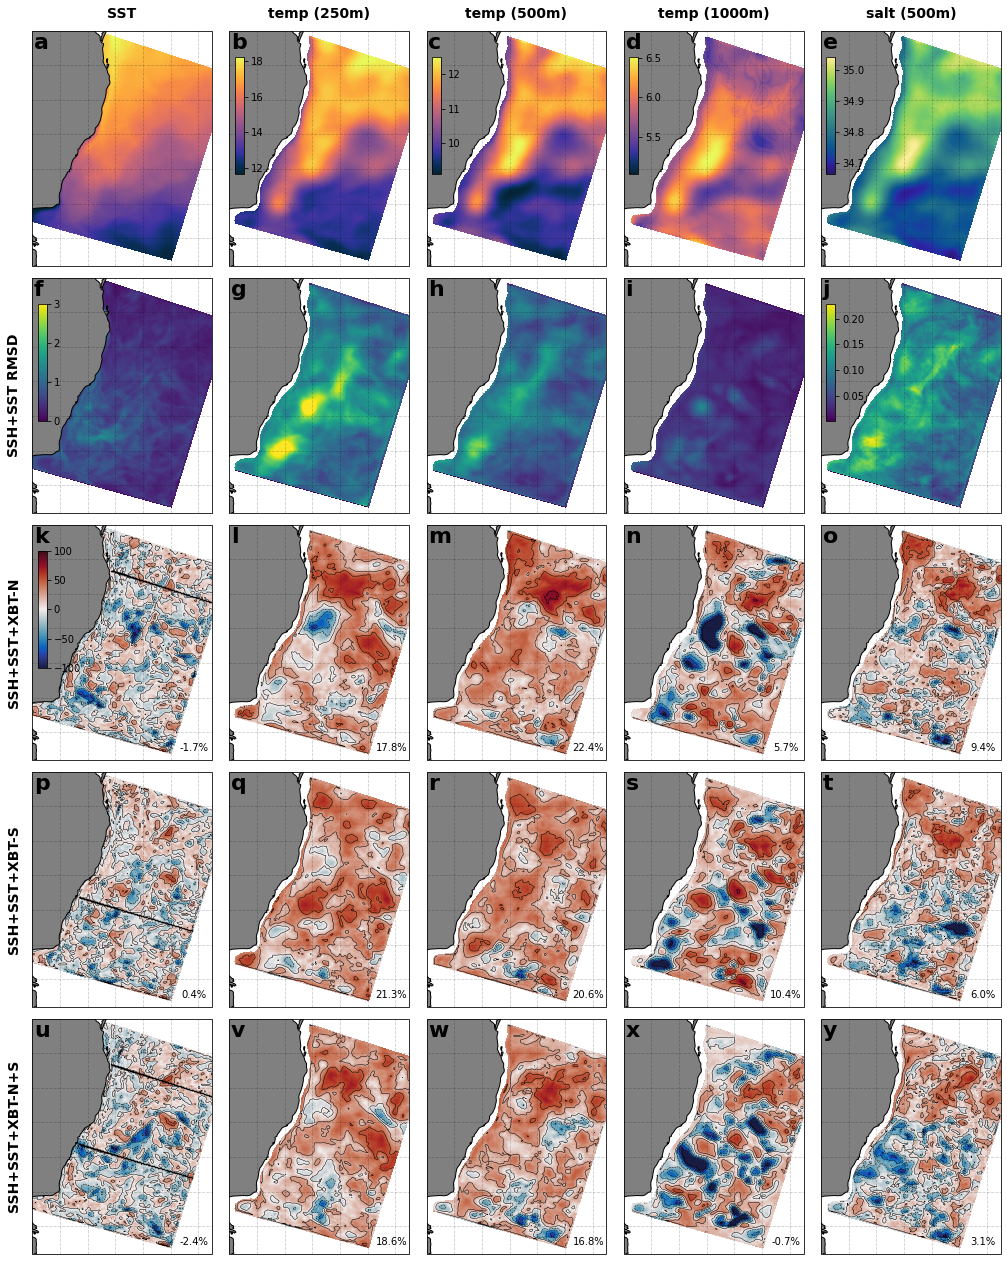

In [47]:
## define

def spatialMap_addGSSubplot(toPlotData, gs, nrow,ncol, labelText, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax

def addSubplot_spatialMap_contourf(input,levels,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.contourf(input.lon_rho,input.lat_rho,input,levels,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax


def addSubplot_spatialMap_pcolor(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
#     cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.07,.39, 1, 1),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
#     fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax

def addSubplot_spatialMap_pcolor_colorbar(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.03,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax



# gs to make a 4 row, 7 col plot
gs = gridspec.GridSpec(nrows=5,ncols=5,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[17.5,22.5])
ax = None



levels=np.arange(-100,110,25)

# add plots
# top row
ax7 = addSubplot_spatialMap_pcolor(truth.temp.isel(s_rho=-1).mean(dim='ocean_time')   ,gs,0,0,'a',pcol_kwargs={'cmap':'cmo.thermal'})
ax7.text(0.5, 1.1, 'SST',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor_colorbar(truth_temp250   ,gs,0,1,'b',pcol_kwargs={'cmap':'cmo.thermal'})
ax7.text(0.5, 1.1, 'temp (250m)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor_colorbar(truth_temp500   ,gs,0,2,'c',pcol_kwargs={'cmap':'cmo.thermal'})
ax7.text(0.5, 1.1, 'temp (500m)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor_colorbar(truth_temp1000   ,gs,0,3,'d',pcol_kwargs={'cmap':'cmo.thermal'})
ax7.text(0.5, 1.1, 'temp (1000m)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor_colorbar(truth_salt500   ,gs,0,4,'e',pcol_kwargs={'cmap':'cmo.haline'})
ax7.text(0.5, 1.1, 'salt (500m)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)


## OSSE_SSHSST row

ax7 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_TRUTH_temp   ,gs,1,0,'f',pcol_kwargs={'vmin':0,'vmax':3})
ax7.text(-.1, .5, 'SSH+SST RMSD',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax7.transAxes)
ax7 = addSubplot_spatialMap_pcolor(RMSD_SSHSST_TRUTH_temp250   ,gs,1,1,'g',pcol_kwargs={'vmin':0,'vmax':3})
ax7 = addSubplot_spatialMap_pcolor(RMSD_SSHSST_TRUTH_temp500   ,gs,1,2,'h',pcol_kwargs={'vmin':0,'vmax':3})
ax8 = addSubplot_spatialMap_pcolor(RMSD_SSHSST_TRUTH_temp1000   ,gs,1,3,'i',pcol_kwargs={'vmin':0,'vmax':3})
ax8 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_TRUTH_salt500   ,gs,1,4,'j',)

## OSSE_SSHSST_XBT_N row
ax5 = addSubplot_spatialMap_pcolor_colorbar(I_XBT_N_temp   ,gs,2,0,'k',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
ax5.text(-.1, .5, 'SSH+SST+XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax5.transAxes)
transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax5.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
ax5.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_N_temp,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax5.transAxes)
I_XBT_N_temp.plot.contour(ax=ax5, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
ax5.set_title('')

ax5 = addSubplot_spatialMap_pcolor(I_XBT_N_temp250   ,gs,2,1,'l',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
I_XBT_N_temp250.plot.contour(ax=ax5, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
ax5.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_N_temp250,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax5.transAxes)
ax5.set_title('')

ax7 = addSubplot_spatialMap_pcolor(I_XBT_N_temp500,gs,2,2,'m',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
I_XBT_N_temp500.plot.contour(ax=ax7, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
ax7.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_N_temp500,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax7.transAxes)
ax7.set_title('')

ax8 = addSubplot_spatialMap_pcolor(I_XBT_N_temp1000   ,gs,2,3,'n',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
I_XBT_N_temp1000.plot.contour(ax=ax8, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
ax8.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_N_temp1000,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)
ax8.set_title('')

ax8 = addSubplot_spatialMap_pcolor(I_XBT_N_salt500   ,gs,2,4,'o',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
I_XBT_N_salt500.plot.contour(ax=ax8, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
ax8.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_N_salt500,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)
ax8.set_title('')

## OSSE_SSHSST_XBT_S row
ax5 = addSubplot_spatialMap_pcolor(I_XBT_S_temp   ,gs,3,0,'p',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
ax5.text(-.1, .5, 'SSH+SST+XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax5.transAxes)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax5.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
ax5.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_S_temp,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax5.transAxes)
I_XBT_S_temp.plot.contour(ax=ax5, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
ax5.set_title('')

ax5 = addSubplot_spatialMap_pcolor(I_XBT_S_temp250   ,gs,3,1,'q',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
I_XBT_S_temp250.plot.contour(ax=ax5, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
ax5.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_S_temp250,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax5.transAxes)
ax5.set_title('')

ax7 = addSubplot_spatialMap_pcolor(I_XBT_S_temp500 ,gs,3,2,'r',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
I_XBT_S_temp500.plot.contour(ax=ax7, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
ax7.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_S_temp500,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax7.transAxes)
ax7.set_title('')

ax8 = addSubplot_spatialMap_pcolor(I_XBT_S_temp1000   ,gs,3,3,'s',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
I_XBT_S_temp1000.plot.contour(ax=ax8, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
ax8.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_S_temp1000,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)
ax8.set_title('')

ax8 = addSubplot_spatialMap_pcolor(I_XBT_S_salt500   ,gs,3,4,'t',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
I_XBT_S_salt500.plot.contour(ax=ax8, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
ax8.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_S_salt500,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)
ax8.set_title('')

## OSSE_SSHSST_XBT row
ax5 = addSubplot_spatialMap_pcolor(I_XBT_temp   ,gs,4,0,'u',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax5.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax5.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
ax5.text(-.1, .5, 'SSH+SST+XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax5.transAxes)
ax5.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_temp,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax5.transAxes)
I_XBT_temp.plot.contour(ax=ax5, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
ax5.set_title('')

ax5 = addSubplot_spatialMap_pcolor(I_XBT_temp250   ,gs,4,1,'v',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
I_XBT_temp250.plot.contour(ax=ax5, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
ax5.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_temp250,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax5.transAxes)
ax5.set_title('')

ax7 = addSubplot_spatialMap_pcolor(I_XBT_temp500   ,gs,4,2,'w',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
I_XBT_temp500.plot.contour(ax=ax7, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
ax7.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_temp500,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax7.transAxes)
ax7.set_title('')

ax8 = addSubplot_spatialMap_pcolor(I_XBT_temp1000   ,gs,4,3,'x',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
I_XBT_temp1000.plot.contour(ax=ax8, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
ax8.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_temp1000,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)
ax8.set_title('')

ax8 = addSubplot_spatialMap_pcolor(I_XBT_salt500   ,gs,4,4,'y',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
I_XBT_salt500.plot.contour(ax=ax8, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
ax8.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_salt500,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)
ax8.set_title('')

